In [1]:
import os
import pandas as pd
import nltk
import requests
import string
from gensim.models import Word2Vec, KeyedVectors
import shutil
import numpy as np
import re
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Attention, Concatenate
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.metrics import accuracy_score, classification_report
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
import shap


In [2]:
FINE_TUNED_DIR = '../../pretained_or_finetune-models'
REVIEWS_DATASET_DIR = '../../dataset'
UTILS_DIR = '../../utils'
NLTK_DATA_PATH = f"{FINE_TUNED_DIR}/nltk_data"

nltk.data.path.append(NLTK_DATA_PATH)

In [3]:
tourism_reviews_en = pd.read_csv(f"{REVIEWS_DATASET_DIR}/eng_reviews_emotion_classify.csv", encoding='utf-8')

columns_to_use = ['helpful_votes', 'location_id', 'review_id', 'review',
                  'review_subject', 'trip_type', 'rating',
                  'location_name', 'province', 'place_id', 'emotion', 'cleaned_review']
columns_to_train = ['location_id', 'review', 'rating']
review_df = tourism_reviews_en[columns_to_use]

In [4]:
tourism_reviews_en.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5909 entries, 0 to 5908
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Unnamed: 0.1    5909 non-null   int64 
 1   Unnamed: 0      5909 non-null   int64 
 2   helpful_votes   5909 non-null   int64 
 3   location_id     5909 non-null   int64 
 4   lang            5909 non-null   object
 5   review_id       5909 non-null   int64 
 6   review          5909 non-null   object
 7   review_subject  5909 non-null   object
 8   trip_type       5892 non-null   object
 9   travel_date     5892 non-null   object
 10  rating          5909 non-null   int64 
 11  location_name   5909 non-null   object
 12  province        5909 non-null   object
 13  place_id        5909 non-null   object
 14  cleaned_review  5909 non-null   object
 15  emotion         5909 non-null   object
dtypes: int64(6), object(10)
memory usage: 738.8+ KB


In [5]:
review_df.describe()

,helpful_votes,location_id,review_id,rating
count,5909.000000,5.909000e+03,5.909000e+03,5909.000000
mean,1.058216,6.483167e+06,7.590446e+08,4.153833
std,5.625108,4.877561e+06,1.844114e+08,1.067077
min,0.000000,3.110380e+05,1.049076e+08,1.000000
25%,0.000000,2.578107e+06,6.573250e+08,4.000000
50%,0.000000,6.017599e+06,7.832754e+08,4.000000
75%,1.000000,8.818088e+06,9.240324e+08,5.000000
max,182.000000,2.714283e+07,9.653184e+08,5.000000


In [6]:
review_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5909 entries, 0 to 5908
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   helpful_votes   5909 non-null   int64 
 1   location_id     5909 non-null   int64 
 2   review_id       5909 non-null   int64 
 3   review          5909 non-null   object
 4   review_subject  5909 non-null   object
 5   trip_type       5892 non-null   object
 6   rating          5909 non-null   int64 
 7   location_name   5909 non-null   object
 8   province        5909 non-null   object
 9   place_id        5909 non-null   object
 10  emotion         5909 non-null   object
 11  cleaned_review  5909 non-null   object
dtypes: int64(4), object(8)
memory usage: 554.1+ KB


In [7]:
review_df

,helpful_votes,location_id,review_id,review,review_subject,trip_type,rating,location_name,province,place_id,emotion,cleaned_review
0,0,2209612,953596359,Besides elegant grand palace and wat pra kaew ...,"The place is nearby grand palace, in the area ...",Family,5,Wat Ratchabophit,Bangkok,P03013220,joy,besides elegant grand palace <OOV> wat pra kae...
1,0,2209612,938998692,This is one of the last big king temples of Ba...,Nice Wat,Solo travel,4,Wat Ratchabophit,Bangkok,P03013220,joy,<OOV> <OOV> one <OOV> <OOV> last big king temp...
2,6,2209612,933065689,"It is beautiful, clean and free to enter. Both...",Nice views,Solo travel,4,Wat Ratchabophit,Bangkok,P03013220,joy,<OOV> <OOV> beautiful clean <OOV> free <OOV> e...
3,0,2209612,885904967,Wat Ratchabophit is a Buddhist temple located ...,Wat Ratchabophit - a temple characterized by u...,Couples,5,Wat Ratchabophit,Bangkok,P03013220,joy,wat ratchabophit <OOV> <OOV> buddhist temple l...
4,4,2209612,782967555,Wat Ratchabophit is a historic royal temple bu...,"Beautiful, peaceful",NONE,5,Wat Ratchabophit,Bangkok,P03013220,joy,wat ratchabophit <OOV> <OOV> historic royal te...
...,...,...,...,...,...,...,...,...,...,...,...,...
5904,0,1831068,888281929,Is quite far from Korat Town or main highway. ...,Can visit.. depends on individual,Family,3,Prasat Puay Noi,Nonthaburi,P03013503,joy,<OOV> quite far <OOV> korat town <OOV> main hi...
5905,4,1831068,752115552,Prasat Pueai Noi is claimed to be the biggest ...,"Small, Isolated Khmer Sanctuary",NONE,3,Prasat Puay Noi,Nonthaburi,P03013503,joy,prasat pueai noi <OOV> claimed <OOV> <OOV> <OO...
5906,0,1831068,693354319,I think this place is claimed to be the oldest...,A sense of ancient times..,Friends getaway,4,Prasat Puay Noi,Nonthaburi,P03013503,joy,<OOV> think <OOV> place <OOV> claimed <OOV> <O...
5907,1,1831068,573376614,The compound comprises three brick buildings o...,Another Angkor Wat,Solo travel,4,Prasat Puay Noi,Nonthaburi,P03013503,joy,<OOV> compound comprises three brick buildings...


In [8]:
from nltk.tokenize import word_tokenize, sent_tokenize
text = "Hello Mr. Smith, how are you doing today? The weather is great and Python is awesome. The sky is pinkish-blue. You should not eat cardboard."
word_tokenize ( text )
sent_tokenize ( text )

['Hello Mr. Smith, how are you doing today?',
 'The weather is great and Python is awesome.',
 'The sky is pinkish-blue.',
 'You should not eat cardboard.']

In [9]:
from nltk.corpus import stopwords 

custom_stopwords = set(stopwords.words('english'))

In [10]:
from nltk.stem import WordNetLemmatizer

stop_words = custom_stopwords
lemmatizer = WordNetLemmatizer()

In [12]:
def advanced_clean_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = re.sub(r'[^a-z\s]', '', text)  # Remove special characters
    text = re.sub(r'\b(u|ur|b4)\b', 'you', text)  # Replace common abbreviations
    words = word_tokenize(text)
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    words = [word for word in words if word not in string.punctuation]
    return ' '.join(words)

In [25]:
# Apply preprocessing to the review texts
review_df['cleaned_review'] = review_df['review'].apply(advanced_clean_text)
vector_size = 300
# 2. สร้าง Word Embeddings ด้วย Word2Vec
# word2vec_model = Word2Vec(sentences=review_df['cleaned_review'], vector_size=300, window=5, min_count=1, sg=1)  # ใช้ Skip-Gram
sentences = [row.split() for row in review_df['cleaned_review']]
word2vec_model = Word2Vec(sentences, vector_size=vector_size, window=5, min_count=1, workers=4)  # เปลี่ยน vector_size เป็น 300



/var/folders/fk/449tdf_12hzd2r7ps4659q0m0000gn/T/ipykernel_68316/3587231279.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_df['cleaned_review'] = review_df['review'].apply(advanced_clean_text)


In [26]:
# Parameters
embedding_dim = 300  # Assuming Word2Vec has 300 dimensions
dropout_rate = 0.5
num_classes = 1  # Binary classification
max_len = 100  # Maximum length of input sequences
ngram_range = (1, 2)  # Unigrams and bigrams
max_features = 20000  

# Create the embedding matrix from the Word2Vec model
word_index = {word: i for i, word in enumerate(word2vec_model.wv.index_to_key)}
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))

In [27]:
def text_to_word2vec(tokens, model, max_length=300):
    vector = np.zeros((max_length, 300))
    for i, word in enumerate(tokens):
        if i < max_length:
            if word in model.wv:
                vector[i] = model.wv[word]
    return vector

review_df['embedding'] = review_df['cleaned_review'].apply(lambda x: text_to_word2vec(x, word2vec_model))


/var/folders/fk/449tdf_12hzd2r7ps4659q0m0000gn/T/ipykernel_68316/1367629667.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_df['embedding'] = review_df['cleaned_review'].apply(lambda x: text_to_word2vec(x, word2vec_model))


In [28]:
def map_rating_to_sentiment(rating):
    if rating in [1, 2]:
        return 'negative'
    elif rating in [3, 4]:
        return 'neutral'
    else:  # 4 or 5
        return 'positive'

review_df['sentiment'] = review_df['rating'].apply(map_rating_to_sentiment)

/var/folders/fk/449tdf_12hzd2r7ps4659q0m0000gn/T/ipykernel_68316/2638035927.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_df['sentiment'] = review_df['rating'].apply(map_rating_to_sentiment)


In [29]:
from sklearn.utils import resample

# Assuming `review_df` is your original DataFrame with a 'sentiment' column

# 1. Separate the data by class
df_positive = review_df[review_df.sentiment == 'positive']
df_neutral = review_df[review_df.sentiment == 'neutral']
df_negative = review_df[review_df.sentiment == 'negative']

# 2. Resample the minority classes
# For example, oversample the neutral and negative classes to match the positive class
df_neutral_upsampled = resample(df_neutral,
                                replace=True,  # Sample with replacement
                                n_samples=len(df_positive),  # Match number of positive class samples
                                random_state=42)  # Reproducible results

df_negative_upsampled = resample(df_negative,
                                 replace=True,  # Sample with replacement
                                 n_samples=len(df_positive),  # Match number of positive class samples
                                 random_state=42)  # Reproducible results

# 3. Combine the resampled DataFrames
df_balanced = pd.concat([df_positive, df_neutral_upsampled, df_negative_upsampled])

# 4. Shuffle the combined DataFrame
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# 5. Check the distribution of the classes
print(df_balanced['sentiment'].value_counts())


sentiment
neutral     2871
positive    2871
negative    2871
Name: count, dtype: int64


In [30]:
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(df_balanced['cleaned_review'])

X = tokenizer.texts_to_sequences(df_balanced['cleaned_review'])
X = pad_sequences(X, maxlen=max_len)

# แปลงคอลัมน์ 'sentiment' เป็นข้อมูลตัวเลข
label_mapping = {'negative': 0, 'neutral': 1, 'positive': 2}
y = df_balanced['sentiment'].map(label_mapping)

In [31]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X, y)

# แบ่งข้อมูลใหม่อีกครั้งหลังจาก SMOTE
X_train_resampled, X_val, y_train_resampled, y_val = train_test_split(X_train_resampled, y_train_resampled, test_size=0.2, random_state=42)

In [32]:
# Check the shapes of the resulting arrays
print(f"X_train shape: {X_train_resampled.shape}")
print(f"y_train shape: {y_train_resampled.shape}")
print(f"X_test shape: {X_val.shape}")
print(f"y_test shape: {y_val.shape}")


X_train shape: (6890, 100)
y_train shape: (6890,)
X_test shape: (1723, 100)
y_test shape: (1723,)


In [33]:
def get_avg_word2vec(text, model, vector_size):
    avg_vec = np.zeros((vector_size,))
    count = 0
    for word in text:
        if word in model.wv:
            avg_vec += model.wv[word]
            count += 1
    if count > 0:
        avg_vec /= count
    return avg_vec

In [34]:
X_train_w2v = np.array([get_avg_word2vec(sentence, word2vec_model, vector_size) for sentence in X_train_resampled])
X_val_w2v = np.array([get_avg_word2vec(sentence, word2vec_model, vector_size) for sentence in X_val])

In [46]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

# สร้างและฝึก Decision Tree model
dt_model = DecisionTreeClassifier()
history = dt_model.fit(X_train_w2v, y_train_resampled)

In [47]:
word_index = tokenizer.word_index
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))

for word, i in word_index.items():
    if i < max_features:
        # ใช้ [] แทนการใช้ get() เพื่อดึง embedding vector
        if word in word2vec_model.wv:
            embedding_vector = word2vec_model.wv[word]
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector

In [48]:
from sklearn.utils.class_weight import compute_class_weight

unique_classes = np.unique(y_train_resampled)

# Compute class weights
class_weights = compute_class_weight('balanced', classes=unique_classes, y=y_train_resampled)
class_weights_dict = dict(enumerate(class_weights))

# Optional: Normalize class weights
total = sum(class_weights_dict.values())
class_weights_dict = {k: v / total for k, v in class_weights_dict.items()}

In [39]:
class_weights_dict = dict(enumerate(class_weights))

In [40]:
class_weights_dict

{0: 1.0064271107215892, 1: 0.9869646182495344, 2: 1.0068683326026597}

In [44]:
y_pred_dt = dt_model.predict(X_val_w2v)

# ประเมินผลลัพธ์
print(classification_report(y_val, y_pred_dt))

              precision    recall  f1-score   support

           0       0.86      0.98      0.92       589
           1       0.66      0.74      0.70       544
           2       0.73      0.54      0.62       590

    accuracy                           0.75      1723
   macro avg       0.75      0.75      0.74      1723
weighted avg       0.75      0.75      0.74      1723



In [50]:
accuracy = accuracy_score(y_val, y_pred_dt)
print(f"Accuracy: {accuracy}")

Accuracy: 0.7539175856065002


### Decision Tree

Cross-validation scores: [0.7394775  0.71552975 0.74238026 0.72351234 0.73367199]
Mean accuracy: 0.7309143686502176


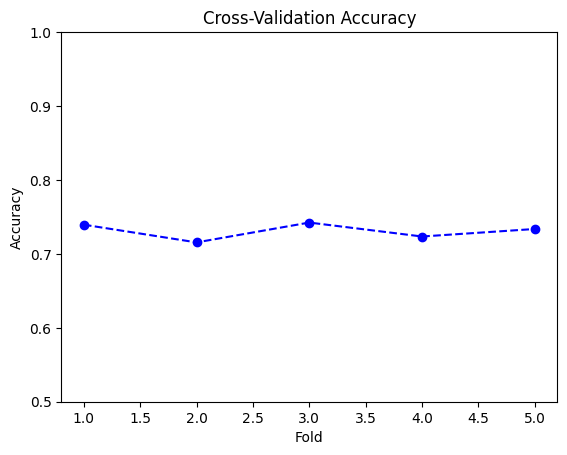

In [51]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

cv_scores = cross_val_score(dt_model, X_train_w2v, y_train_resampled, cv=5, scoring='accuracy')

# แสดงค่าความแม่นยำในแต่ละ fold
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean accuracy: {cv_scores.mean()}")

# สร้างกราฟแสดงความแม่นยำในแต่ละ fold
plt.plot(range(1, len(cv_scores) + 1), cv_scores, marker='o', linestyle='--', color='b')
plt.title('Cross-Validation Accuracy')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])  # ตั้งค่าให้แกน Y มีช่วง 0.5 ถึง 1 เพื่อให้เห็นชัดเจน
plt.show()

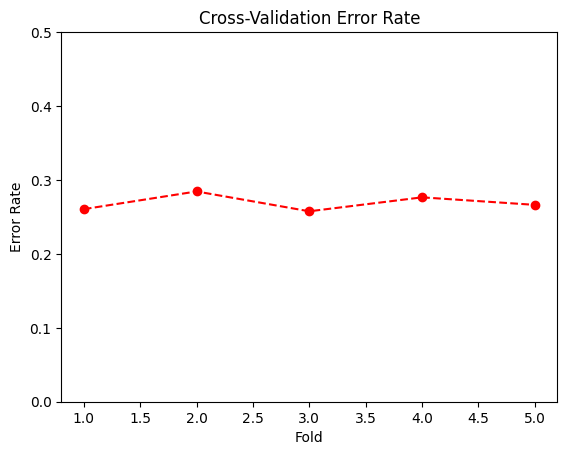

In [57]:
error_rate = 1 - cv_scores

# สร้างกราฟแสดง error rate
plt.plot(range(1, len(error_rate) + 1), error_rate, marker='o', linestyle='--', color='r')
plt.title('Cross-Validation Error Rate')
plt.xlabel('Fold')
plt.ylabel('Error Rate')
plt.ylim([0, 0.5])
plt.show()

### K-Nearest-Neighbors

In [53]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score

# สร้างโมเดล KNN (กำหนดค่า k เท่ากับ 5)
knn_model = KNeighborsClassifier(n_neighbors=5)

# ฝึกโมเดล KNN ด้วยข้อมูลฝึก
knn_model.fit(X_train_w2v, y_train_resampled)

# ทำนายผลลัพธ์บนชุดข้อมูล validation
y_pred_knn = knn_model.predict(X_val_w2v)

# ประเมินความแม่นยำ
accuracy = accuracy_score(y_val, y_pred_knn)
print(f"Accuracy: {accuracy}")

# แสดงรายงานการจัดหมวดหมู่ (classification report)
print(classification_report(y_val, y_pred_knn))


Accuracy: 0.5972141613464886
              precision    recall  f1-score   support

           0       0.64      0.93      0.76       589
           1       0.55      0.51      0.53       544
           2       0.57      0.35      0.43       590

    accuracy                           0.60      1723
   macro avg       0.58      0.60      0.57      1723
weighted avg       0.59      0.60      0.57      1723



### Naive Bayes

In [65]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, accuracy_score

# สร้างโมเดล Gaussian Naive Bayes
gnb_model = GaussianNB()

# ฝึกโมเดลด้วยข้อมูลฝึก
gnb_model.fit(X_train_w2v, y_train_resampled)

# ทำนายผลลัพธ์บนชุดข้อมูล validation
y_pred_gnb = gnb_model.predict(X_val_w2v)

# ประเมินความแม่นยำ
accuracy = accuracy_score(y_val, y_pred_gnb)
print(f"Accuracy: {accuracy}")

# แสดงรายงานการจัดหมวดหมู่
print(classification_report(y_val, y_pred_gnb))


Accuracy: 0.3401044689495067
              precision    recall  f1-score   support

           0       0.39      0.31      0.35       589
           1       0.32      0.67      0.44       544
           2       0.32      0.06      0.10       590

    accuracy                           0.34      1723
   macro avg       0.34      0.35      0.29      1723
weighted avg       0.34      0.34      0.29      1723



### XGBoost

In [63]:
import xgboost as xgb
from sklearn.metrics import classification_report, accuracy_score

# สร้างโมเดล XGBoost
xgb_model = xgb.XGBClassifier(n_estimators=100, max_depth=5, learning_rate=0.1, subsample=0.8)

xgb_model.fit(X_train_w2v, y_train_resampled)

# ทำนายผลลัพธ์บนชุดข้อมูล validation
y_pred_xgb = xgb_model.predict(X_val_w2v)

# ประเมินความแม่นยำ
accuracy = accuracy_score(y_val, y_pred_xgb)
print(f"Accuracy: {accuracy}")

# แสดงรายงานการจัดหมวดหมู่
print(classification_report(y_val, y_pred_xgb))


Accuracy: 0.706326175275682
              precision    recall  f1-score   support

           0       0.82      0.93      0.87       589
           1       0.63      0.65      0.64       544
           2       0.65      0.54      0.59       590

    accuracy                           0.71      1723
   macro avg       0.70      0.70      0.70      1723
weighted avg       0.70      0.71      0.70      1723



###  Random Forest

In [58]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# สร้างโมเดล Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# ฝึกโมเดลด้วยข้อมูลฝึก
rf_model.fit(X_train_w2v, y_train_resampled)

# ทำนายผลลัพธ์บนชุดข้อมูล validation
y_pred_rf = rf_model.predict(X_val_w2v)

# ประเมินความแม่นยำ
accuracy = accuracy_score(y_val, y_pred_rf)
print(f"Accuracy: {accuracy}")

# แสดงรายงานการจัดหมวดหมู่ (classification report)
print(classification_report(y_val, y_pred_rf))


Accuracy: 0.7800348229831688
              precision    recall  f1-score   support

           0       0.93      0.98      0.96       589
           1       0.68      0.70      0.69       544
           2       0.71      0.65      0.68       590

    accuracy                           0.78      1723
   macro avg       0.77      0.78      0.78      1723
weighted avg       0.78      0.78      0.78      1723



In [ ]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import numpy as np

# กำหนดจำนวน fold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# สร้างโมเดลที่ต้องการประเมิน
models = {
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "Naive Bayes": GaussianNB(),
    "XGBoost": xgb.XGBClassifier(n_estimators=100, max_depth=5, learning_rate=0.1, subsample=0.8)
}

# ฟังก์ชันประเมินโมเดลแต่ละตัวด้วย K-Fold
def evaluate_model(model, X, y):
    scores = cross_val_score(model, X, y, cv=kf, scoring='accuracy')
    return scores

# ประเมินโมเดลแต่ละตัวด้วย K-Fold Cross-Validation
results = {}
for model_name, model in models.items():
    scores = evaluate_model(model, X_train_w2v, y_train_resampled)
    results[model_name] = scores
    print(f"{model_name} Accuracy: {np.mean(scores):.4f} (+/- {np.std(scores):.4f})")

# แสดงผลลัพธ์ของแต่ละโมเดล
for model_name, scores in results.items():
    print(f"{model_name}: Mean Accuracy = {np.mean(scores):.4f}, Std = {np.std(scores):.4f}")
